### Written by Alvin Modin 09/22/2022 ### 


In [1]:


import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import scipy
from skimage import io
from skimage import measure
from skimage import morphology
from scipy import optimize 
from skimage import feature
import matplotlib as mpl
import pandas as pd
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from sympy.utilities.lambdify import lambdify,lambdastr
import sympy as sym

import trackpy as tp

from alive_progress import alive_bar
import time
from matplotlib import ticker
sqrt = np.sqrt

In [2]:
mpl.rcParams.update({'font.size': 40})
label_size = 30
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
mpl.rc('text', usetex=True)
mpl.rcParams['font.family'] = ['serif']

## Processing temperature data

In [3]:
dirName = './'
tempDataFileName = 'temperatures.csv'
fullTempPath = dirName + tempDataFileName

In [4]:
#Import the temperature csv data file

tData = pd.read_csv(fullTempPath)

In [5]:
# Frames per second

fps = 1/5

In [6]:
start = 1245
stop  = 17975

temp = tData[1245:17975:int(1/fps)]['TC'].values
transitionTemp = tData[1209:1212]['TC'].mean()

## Plot first temperature for first 5000 sec.


Text(0.5, 0, 'time[s]')

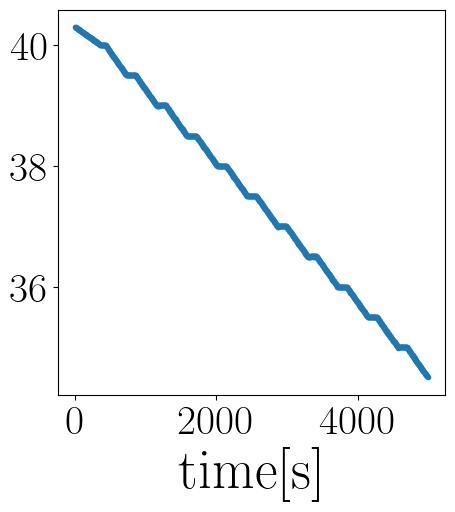

In [7]:
fig, ax = plt.subplots( figsize=(5,5) )



times = np.arange(0,len(temp[:1000])*5,5)
ax.plot(times, temp[:1000],'.')
ax.set_xlabel('time[s]')

## Import Movie

## Note ProcessedMovie.avi should be converted to a .tif

In [16]:
dirName = './'




image = io.imread('processedMovie.tif')
pixCalib = 1/0.18 #pix/um


TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


### Function to detect edges

In [17]:
def edgeDetection(image):
    """
    Input:

    img = .tif image sequence

    Output: 

    array of 1's and 0's after dilation, corresponding to contours"""


# Find the edges, output is an array of 1s and 0s corresponding to edges of the defect line

    cannyEdges = []

    with alive_bar(len(image), force_tty=True) as bar:

        for i in range(len(image)):
    
            edges = feature.canny(image[i],low_threshold=10,high_threshold=50,sigma=3)
            cannyEdges.append(edges)
            
            time.sleep(0.05)
            bar()

    cannyEdges =np.array(cannyEdges).astype(int)

    # Dilate the each image in the array 
    cannyEdges = morphology.binary_closing(cannyEdges).astype(int)
    cannyEdges = morphology.binary_dilation(cannyEdges)

    return cannyEdges

## Function to compute curvature

In [18]:

def computeCurvature(img,mpp = 1/pixCalib):
    """Input:

    img = .tif image sequence

    Output: 

    curvature by least squares fit of a circle"""
    
    def calc_R(xc, yc):
        """ calculate the distance of each 2D points from the center (xc, yc) """
        return np.sqrt((x-xc)**2 + (y-yc)**2)

    def f_2(c):
        """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
        Ri = calc_R(*c)
        return Ri - Ri.mean()



            

    # If image is empty, ignore it and assign curvature of 0 
    
    if np.all(img==0):
        R_2, std, center = 0, 0, np.array([0,0])
        return R_2, std,center,0,0


    
    # Else compute the curvature by fitting a circle
    
    else:

       
        #On the pre-processed image, find the edges, aka the contours

        cs = measure.find_contours(img,0.8,positive_orientation='low')

        #Output array is flattened to a list of x,y coordinates - no care is given to specific contours

        flatten  = [item for sublist in cs for item in sublist]
        # flatten  = sorted(flatten, key=lambda x: x[0])
        flatten  = np.stack(flatten,axis=0)           
        
        x,y = flatten[:,1], flatten[:,0] #bug here that is fixed by adding f_2 and calc_R into this function
                                         #unable to directly feed into the function
        df  = pd.DataFrame({'x':x,'y':y}).to_csv('test')
        x_m = np.mean(x)
        y_m = np.mean(y)


        center_estimate = x_m, y_m
        center_1, ier = optimize.leastsq(f_2, center_estimate)

        xc_1, yc_1 = center_1
        Ri_1       = calc_R(xc_1,yc_1)
        R_1        = Ri_1.mean()

        std        = np.std(Ri_1)/np.sqrt(len(Ri_1))
        circle1    = plt.Circle((xc_1, yc_1), R_1, color='red',alpha=1)

        x,y = flatten[:,1], flatten[:,0] #bug here that is fixed by adding f_2 and calc_R into this function





        return R_1,std,center_1, x,y


            



## Run

### Generate contours by finding edges

In [19]:
cannyEdges = edgeDetection(image).astype(int)


|████████████████████████████████████████| 3346/3346 [100%] in 3:41.0 (15.14/s)                                         


In [20]:
## Drop frames corresponding to where phase transition is taking place, resulting in superfluous edges being detected

dropFrames = np.arange(2111,2131,1) 
saveTemps = np.delete(np.arange(len(cannyEdges)),dropFrames)

## Find individual radii, centers  - 3 parameter fitting

In [21]:
R = []
dr = []
centers = []
xdata = []
ydata = []
with alive_bar(len(image), force_tty=True) as bar:
    for i in range(len(image)):
#         print(i)
        R_,dr_,c,X,Y = computeCurvature(cannyEdges[i])
        R.append(R_)
        xdata.append(X)
        ydata.append(Y)
        dr.append(dr_)
        centers.append(c)
        time.sleep(0.05)
        bar()

R = np.array(R)
dr = np.array(dr)

|████████████████████████████████████████| 3346/3346 [100%] in 4:13.2 (13.21/s)                                         


In [22]:
xc, yc = np.vstack(centers)[:,0], np.vstack(centers)[:,1]
rc = R

In [23]:
# _,_,_,df = computeCurvature(cannyEdges[30])

## Make sure the fitting works ok

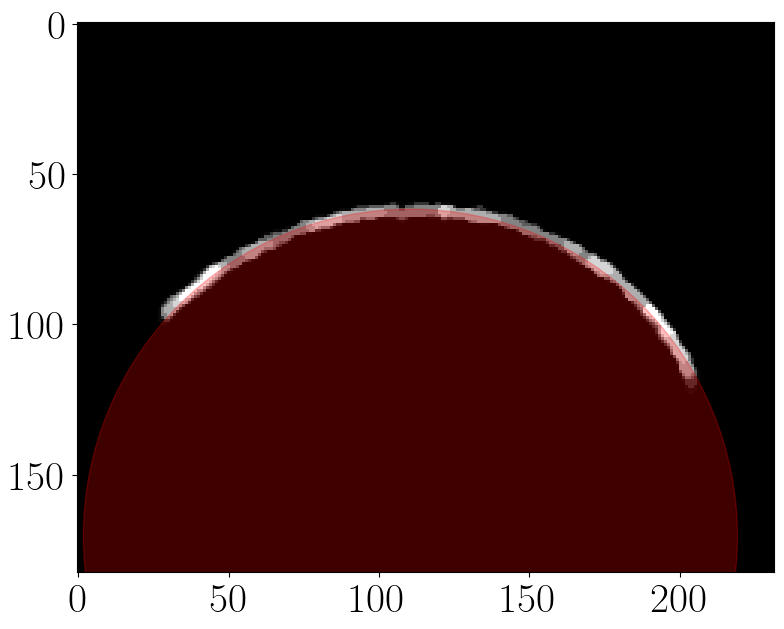

In [25]:
a =255
circle1 = plt.Circle(centers[a],R[a],color='red',alpha=0.25)
fig,ax = plt.subplots(figsize=(9,9))
ax.imshow(image[a],cmap='gray')



ax.add_patch(circle1)


## Define a cost function thatcreates a scalar field at each frame representing the absolute difference of a point from a given circle. 
## Minimize the cost function with respect to   x and y

## $$\sum_i\left(\frac{(x-x_i^c)^2+(y-y_i^c)^2)}{r_i^2}-1\right)^2$$

In [26]:
dimx, dimy = image.shape[::-1][:2]

x,y = np.arange(0,dimx), np.arange(0,dimy)

X,Y = np.meshgrid(x,x)

In [27]:

def costFunction(x,xc,yc,rc):
    Z = []
    for i,j,k in zip(xc,yc,rc):
        
        z = ( ( ( x[0]-i )**2+ ( x[1]-j )**2 )/k**2 - 1)**2
        Z.append(z)
    
    Z = np.sum(Z, axis = 0)
    return Z

In [28]:
rc_ = np.delete(rc,dropFrames)
xc_ = np.delete(xc,dropFrames)
yc_ = np.delete(yc,dropFrames)


In [29]:
Z = costFunction((X,Y),xc_,yc_,rc_)

## Plot below shows the circles fit over the frames of the video, contours indicate regions where there is a minimum value of the cost function  

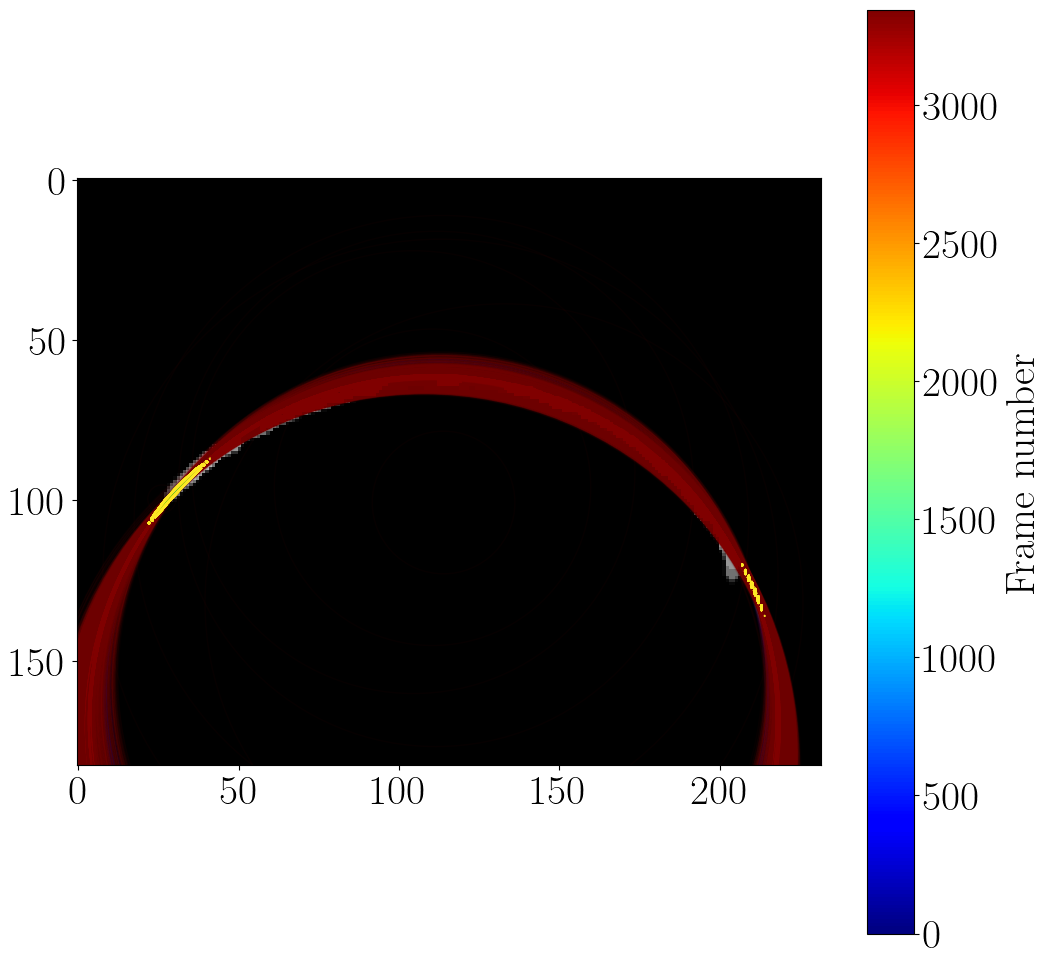

In [30]:
fig, ax = plt.subplots(figsize=(12,12))
levels = np.arange(np.min(Z)-0.5,np.min(Z)+0.5,0.001)

c = np.arange(0,len(R),1)
colors = [mpl.cm.jet(color) for color in c] 
for center,radius,color in zip(centers,R,colors[:]):
    x,y = center
    cirlce1 = plt.Circle((x,y),radius,fill=False, color=color, alpha=0.05)
    ax.add_artist(cirlce1)
x,y = np.vstack(centers)[:,0],np.vstack(centers)[:,1]
ax.contour(X, Y, Z,levels=levels,alpha=1);

plt.scatter(x,y,s=0, c=c, cmap='jet',)
cbar = plt.colorbar()  # this works because of the scatter
cbar.set_label('Frame number',fontsize=30)
# ax.plot(x1, y1, 'o', color = 'C0', ms=15,  alpha =0.8)
# ax.plot(x2, y2, 'o', color = 'C1', ms=15, alpha=0.8)

ax.imshow(image[300],cmap='gray',origin='upper')
ax.grid(False)

## Constrain minimization to find the first point

In [31]:

x_0 = [24,100] #(initial guess)

result = scipy.optimize.minimize(costFunction, x_0, args = (xc_,yc_,rc_), method='SLSQP')
x_1,y_1 = result.x
x_1,y_1

(30.128989942545736, 97.36846177386413)

### Estimate uncertainty from cost function value

In [44]:
dXY_1 =((result.fun)/np.sqrt(float((xc_.size))))

## Constrain minimization to find the second point

In [45]:
bds = [(150,300),(0,200)]
x_0_2 = [225,34] #(initial guess)

result = scipy.optimize.minimize(costFunction, x_0_2, args = (xc_,yc_,rc_), bounds = bds, method='SLSQP')
x_2,y_2 = result.x
x_2,y_2

(210.65190725237167, 127.77538872995098)

### Estimate uncertainty from cost function value

In [46]:
dXY_2 = ((result.fun)/np.sqrt(float((xc_.size))))

### Find distance, $l$ between points and uncertainty $\delta l$ 


In [47]:
l = np.sqrt((y_2-y_1)**2+(x_2-x_1)**2)*(1/pixCalib)
dl = np.sqrt(dXY_1**2+dXY_2**2)*l

l, dl

(32.95185272701981, 0.34636809458771706)

## Convert kappa to radius of curature

# $$ \kappa = \frac{1}{R}$$ 
# $$ \delta \kappa = \frac{\delta R}{R^2}$$